# Neural Agent Memory Analysis

This notebook analyzes the training memory of a neural agent to understand its performance and behavior over time. It loads the agent's memory, calculates win rates, and visualizes action distributions.

In [1]:
# Import necessary libraries
from pathlib import Path
import pickle
import numpy as np
from typing import List, Tuple

# Assuming src is in the python path or adjust sys.path if needed
import sys
sys.path.append('../') # Example if running from notebooks dir

from src.engine.actions import Action
from src.analysis.memory_analyzer import analyze_win_loss_and_steps, calculate_win_rate_over_time, analyze_and_plot_win_rates_by_starting_position

In [2]:
from src.nn.memory_data import MemoryData
from src.analysis.memory_loader import load_memory
from src.analysis.action_analyzer import analyze_actions

# Get the user's home directory
home_dir = Path.home()

# Construct the path to the Downloads folder (or wherever your memory file is)
downloads_dir = home_dir / "Downloads"

# Find the most recently updated .pkl file in the Downloads folder
pkl_files = list(downloads_dir.glob("*.pkl"))
if not pkl_files:
    raise FileNotFoundError("No .pkl memory files found in Downloads")
memory_file = max(pkl_files, key=lambda f: f.stat().st_mtime)

# Load the memory
agent_memory = load_memory(memory_file)

Successfully loaded 10011 episodes from C:\Users\timmie\Downloads\memory_16384.pkl.


Analyzed 10011 completed episodes for outcomes and steps.
First player episodes: 5042, Second player episodes: 4969
Total actions analyzed: 0
Analyzed 10011 completed episodes for outcomes and steps.
First player episodes: 5042, Second player episodes: 4969
Total actions analyzed: 0
Overall win rate (latest 128 episodes): 72.84% over 10011 episodes
Win rate when agent starts first (latest chunk): 74.51% over 5042 episodes
Win rate when agent starts second (latest chunk): 71.14% over 4969 episodes


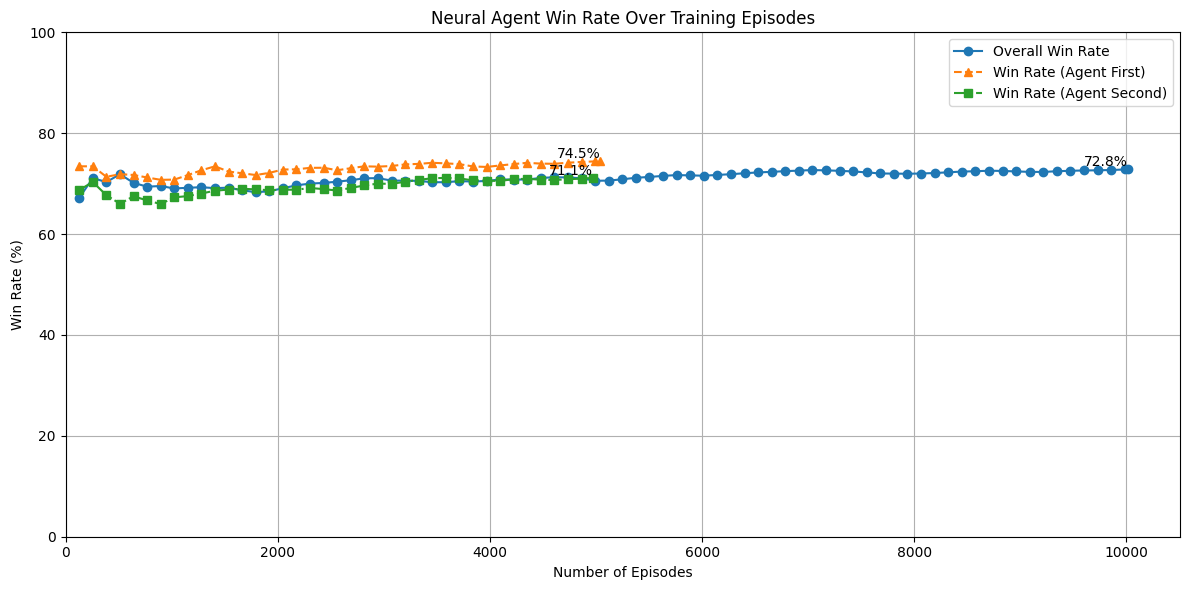

No action data to plot.


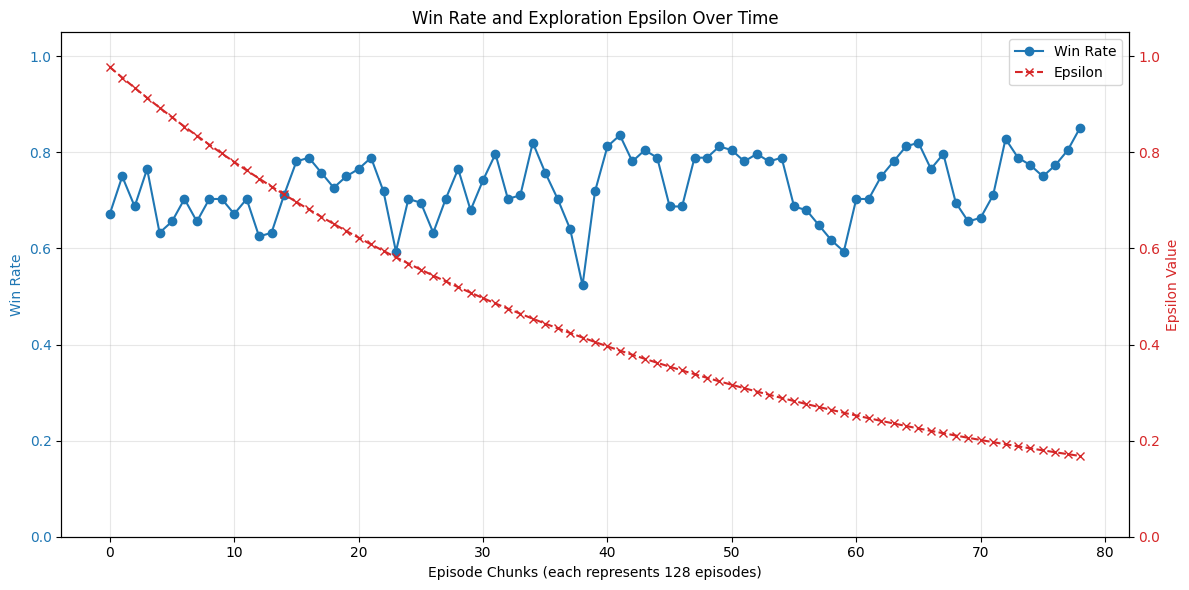

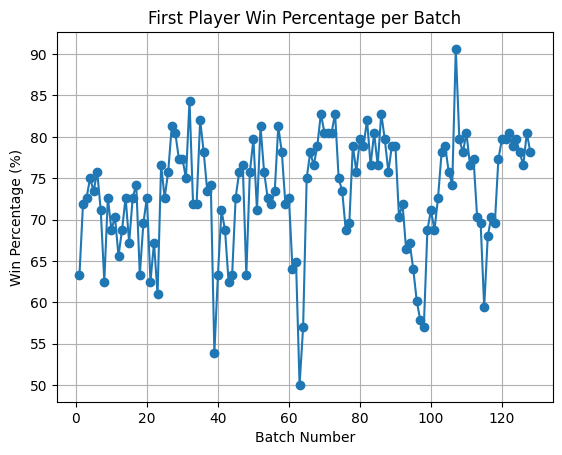


--- Analysis Summary ---
Total valid episodes analyzed: 10011
Overall Win Rate: 72.84%
Average steps per episode: 122.74
Median steps per episode: 119.0
Min steps per episode: 37
Max steps per episode: 361


In [3]:
from src.analysis.visualization import plot_win_rate_and_epsilon

if agent_memory:
    # Analyze win/loss outcomes, steps per episode, and action counts
    episode_outcomes, first_player_outcomes, second_player_outcomes, episode_steps, action_distribution = analyze_win_loss_and_steps(agent_memory.episodes)

    if episode_outcomes:
        # Calculate win rate over time (e.g., in chunks of 100 episodes)
        chunk_size = agent_memory.batch_size

        chunks, rates = calculate_win_rate_over_time(episode_outcomes, chunk_size)

        # Plot win rates by starting position (using existing function)
        analyze_and_plot_win_rates_by_starting_position(memory=agent_memory.episodes, chunk_size=chunk_size)
        
        # Plot win rate with exploration epsilon (using our new function)
        plot_win_rate_and_epsilon(
            episode_outcomes,
            chunk_size=chunk_size,
            initial_epsilon=agent_memory.exploration_decay_rate,
            decay_interval=chunk_size
        )
        
        # Plot batch winners over time
        import matplotlib.pyplot as plt
        batch_winners = agent_memory.batch_winners
        first_player_win_percentages = []
        for winner_dict in batch_winners:
            # Assuming the first player is the first key in the dict
            first_player_id = list(winner_dict.keys())[0]
            total_wins = sum(winner_dict.values())
            win_count = winner_dict.get(first_player_id, 0)
            percentage = (win_count / total_wins) * 100 if total_wins > 0 else 0
            first_player_win_percentages.append(percentage)
        # Plotting
        batches = range(1, len(first_player_win_percentages) + 1)
        plt.figure()
        plt.plot(batches, first_player_win_percentages, marker='o')
        plt.title("First Player Win Percentage per Batch")
        plt.xlabel("Batch Number")
        plt.ylabel("Win Percentage (%)")
        plt.grid(True)
        plt.show()

        # Print overall summary
        overall_win_rate = np.mean(episode_outcomes) * 100
        print(f"\n--- Analysis Summary ---")
        print(f"Total valid episodes analyzed: {len(episode_outcomes)}")
        print(f"Overall Win Rate: {overall_win_rate:.2f}%")

        # Calculate and print step statistics
        if episode_steps:
            avg_steps = np.mean(episode_steps)
            median_steps = np.median(episode_steps)
            min_steps = np.min(episode_steps)
            max_steps = np.max(episode_steps)
            print(f"Average steps per episode: {avg_steps:.2f}")
            print(f"Median steps per episode: {median_steps}")
            print(f"Min steps per episode: {min_steps}")
            print(f"Max steps per episode: {max_steps}")
        else:
            print("No step data available for completed episodes.")

    else:
        print("No valid episode outcomes found to calculate statistics.")
else:
    print("Could not load memory or memory is empty.")
